<a href="https://colab.research.google.com/github/RayCyder/Intro/blob/main/ResNet_Implementation_on_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

In [25]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import numpy as np
np.random.seed(42)


#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**
#**CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Subset, random_split, DataLoader
transform = transforms.Compose([
    # transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
batch_size = 128
# --- Load full CIFAR-10 train set ---
trainset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# --- (Optional) use only a subset for speed
subset_indices = []
targets = np.array(trainset_full.targets)
for c in np.unique(targets):
  class_idx = np.where(targets == c)[0]
  np.random.shuffle(class_idx)
  subset_indices.extend(class_idx[:500])

# Convert subset_indices to a numpy array to allow advanced indexing
subset_indices = np.array(subset_indices)

#train_subset = Subset(trainset_full, subset_indices)

# --- Split subsert into train/validation ---
train_indices = []
val_indices = []
val_ratio = 0.1
subset_labels = targets[subset_indices]
for c in np.unique(subset_labels):
  class_idx = np.where(subset_labels == c)[0]
  np.random.shuffle(class_idx)
  n_val = int(len(class_idx)*val_ratio)
  val_indices.extend(subset_indices[class_idx[:n_val]])
  train_indices.extend(subset_indices[class_idx[n_val:]])
#train_set,val_set = random_split(train_subset,[n_train,n_val])
train_set = Subset(trainset_full,train_indices)
val_set  = Subset(trainset_full, val_indices)
# --- DataLoaders ---
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set,batch_size = batch_size,shuffle=False)
# --- Test Set ---
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
# --- Class names ---
classes = trainset_full.classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']
print(classes)
print(f"Batch size:{batch_size}, \
      Train batches:{len(train_loader)}, \
      Val batches:{len(val_loader)},\
      Test batches:{len(test_loader)}")
# check train and val set is balanced or not
from collections import Counter
train_labels = [classes[x] for x in targets[train_indices]]
val_labels = [classes[x] for x in targets[val_indices]]
print("Train class counts:",Counter(train_labels))
print("Val class counts:", Counter(val_labels))

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size:128,       Train batches:36,       Val batches:4,      Test batches:79
Train class counts: Counter({'airplane': 450, 'automobile': 450, 'bird': 450, 'cat': 450, 'deer': 450, 'dog': 450, 'frog': 450, 'horse': 450, 'ship': 450, 'truck': 450})
Val class counts: Counter({'airplane': 50, 'automobile': 50, 'bird': 50, 'cat': 50, 'deer': 50, 'dog': 50, 'frog': 50, 'horse': 50, 'ship': 50, 'truck': 50})


#**Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(3, 32, 32)


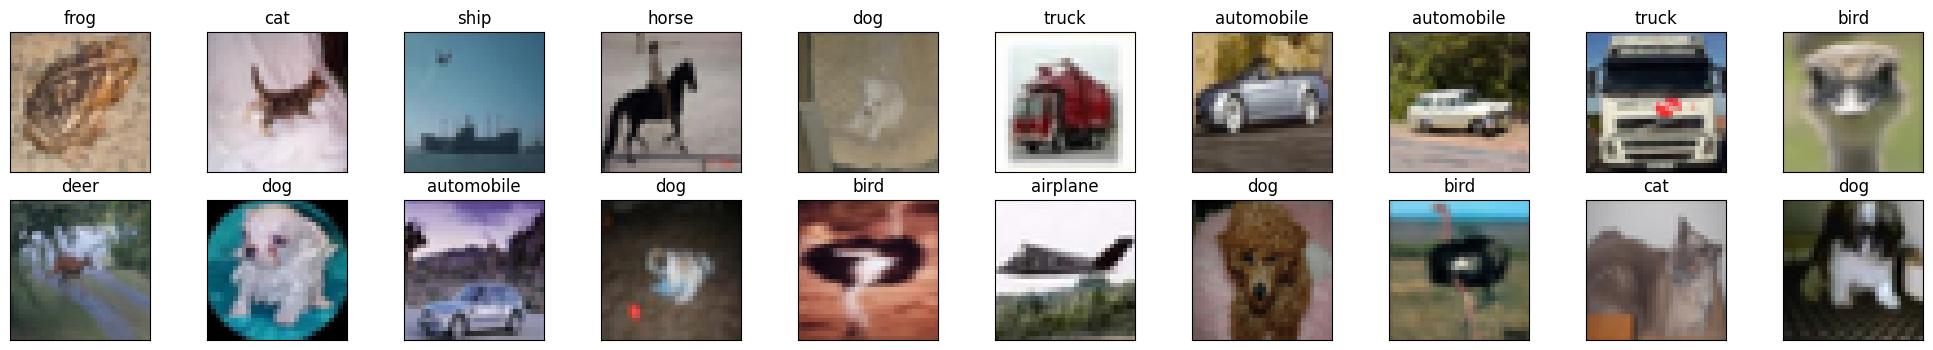

In [27]:
import matplotlib.pyplot as plt
import numpy as np
print(classes)
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print(images[0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#**Defining the Network Architecture**
In this section the entire Research Paper is implemented to define the Residual Network approach taken by the researchers

NOTE:

Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# choose device
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")
def initialize_model(device):
  # Load a pre-defined ResNet18
  ResNet18 = models.resnet18(weights=None)   # train from scratch
  # or use pretrained weights:
  # model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

  # Adjust the final layer for your dataset (e.g. 10 classes for CIFAR-10)
  num_ftrs = ResNet18.fc.in_features
  ResNet18.fc = nn.Linear(num_ftrs, 10)
  ResNet18 = ResNet18.to(device)
  if device == "cuda":
    import torch.backends.cudnn as cudnn
    ResNet18 = torch.nn.DataParallel(ResNet18)
    cudnn.benchmark = True
  return ResNet18
resnet18 = initialize_model(device)

Using device: cuda


#**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf) as Optimizer with momentum and weight decay specified by the research paper of ResNet

In [29]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
# specify optimizer
# optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


In [30]:
'''
Muon-MVR For LLM Pretraining.
'''
import torch
import math


@torch.compile
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X

class MuonMVR(torch.optim.Optimizer):
    r'''
    Standard MVR:\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t})
    Approximate MVR:
        1.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t-1};\xi_{t-1})
        2.\\(nabla f(X_t;\xi_t) - \\nabla f(X_{t};\xi_{t-1}), It has low computational complexity
         and is more convenient in practice
    '''
    def __init__(self, params, lr=3e-3, momentum = 0.95 ,adamw_betas=(0.95, 0.99), eps=1e-8,
                 weight_decay=0.0, gamma=0.025, is_approx=False):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum parameter: {momentum}")
        if not 0.0 <= adamw_betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {adamw_betas[0]}")
        if not 0.0 <= adamw_betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {adamw_betas[1]}")

        defaults = dict(lr=lr, momentum=momentum,adamw_betas=adamw_betas, eps=eps,
                       weight_decay=weight_decay, gamma=gamma)
        super().__init__(params, defaults)
        self.is_approx = is_approx

    def adjust_lr_for_muon(self, lr, param_shape):
        A, B = param_shape[:2]
        # We adjust the learning rate and weight decay based on the size of the parameter matrix
        # as describted in the paper
        adjusted_ratio = 0.2 * math.sqrt(max(A, B))
        # adjusted_ratio = math.sqrt(A*B)
        adjusted_lr = lr * adjusted_ratio
        return adjusted_lr

    @torch.no_grad()
    def update_last_grad(self):
        if not self.is_approx:
            for group in self.param_groups:
                for p in group['params']:
                    state = self.state[p]
                    if "last_grad" not in state:
                        state["last_grad"] = torch.zeros_like(p)
                    state["last_grad"].zero_().add_(p.grad, alpha=1.0)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['adamw_betas']
            eps = group['eps']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            gamma = group['gamma']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['last_grad'] = torch.zeros_like(p)
                    # state['previous_grad'] = torch.zeros_like(p)
                    if len(p.shape) != 2:  # Only for 2D tensors
                        state['exp_avg_sq'] = torch.zeros_like(p)

                state['step'] += 1
                last_grad = state['last_grad']
                if len(p.shape) == 2:
                    exp_avg = state['exp_avg']

                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (momentum / (1. - momentum))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    # Update moving averages
                    exp_avg.mul_(momentum).add_(c_t, alpha=1 - momentum)
                    update = zeropower_via_newtonschulz5(exp_avg.mul(1./(1.- momentum))) # whiten the update
                    adjusted_lr = self.adjust_lr_for_muon(lr, p.shape)
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(update, alpha=-adjusted_lr)
                else:
                    # For bias vectors - use simple update
                    step = state['step']
                    # Compute momentum-like term with correction
                    c_t = (grad - last_grad).mul(gamma * (beta1 / (1. - beta1))).add(grad)
                    c_t_norm = torch.norm(c_t)
                    # avoid inductor lowering bug: compute norm explicitly and detach
                    # c_t_norm = torch.sqrt(torch.sum((c_t.detach() * c_t.detach()), dim=None))
                    if c_t_norm > 1.:
                        c_t = c_t / c_t_norm
                    exp_avg = state['exp_avg']
                    exp_avg_sq = state['exp_avg_sq']
                    exp_avg.lerp_(c_t, 1 - beta1)
                    exp_avg_sq.lerp_(c_t.square(), 1 - beta2)
                    g = exp_avg / (eps + exp_avg_sq.sqrt())
                    bias_correction1 = 1 - beta1**step
                    bias_correction2 = 1 - beta2**step
                    scale = bias_correction1 / bias_correction2**0.5
                    p.data.mul_(1 - lr * weight_decay)
                    p.data.add_(g, alpha=-lr / scale)

                if self.is_approx:
                    state['last_grad'].copy_(grad)

#**MuonMVR Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

## MVR2 Usage
3.  **Optimizer Modes**
    MuonMVR can be initialized in different modes to trade off between precision and computational cost.

    **Exact Variance Reduction (`is_approx=False`)**
    To achieve the most precise variance reduction, you must manually manage the model state. Before calculating the gradient for the previous batch, you need to load the model state from the previous iteration. This ensures that the gradient is computed with the correct model weights.
    ```python
    optimizer = MuonMVR(model.parameters(), lr=1e-3, is_approx=False)
    old_state_dict = {}
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Store the current model state
        cur_state_dict = {k: v.data.clone() for k, v in net.state_dict().items()}
    
        if old_state_dict:
            # Load the previous model state to compute the old gradient
            net.load_state_dict(old_state_dict)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.update_last_grad()
    
        # Restore the current model state to compute the new gradient
        net.load_state_dict(cur_state_dict)
        old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
        
        # Standard forward/backward pass and step
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    ```

In [31]:
class BaseOptimizer(object):
  def __init__(self,model,criterion,epochs):
    self.model = model
    self.epochs = epochs
    self.criterion = criterion
    self.optimizer,self.scheduler = None, None
  def initialize_optimzer(self):
    raise Exception("non implemetation")
  def zero_grad(self,inputs=None,labels=None):
    self.optimizer.zero_grad()
  def step(self):
    self.optimizer.step()
  def epoch_step(self):
    if self.scheduler:
      self.scheduler.step()

class MuonMVR2Optimizer(BaseOptimizer):
  def __init__(self,model,criterion,epochs):
    super().__init__(model,criterion,epochs)
    self.old_state_dict = {}
  def initialize_optimizer(self, learning_rate):
    optimizer = MuonMVR(self.model.parameters(), lr=learning_rate,weight_decay=0.01,gamma=0.1,is_approx=False)
    # Cosine annealing: lr → eta_min by the end
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,   # period (usually = total epochs)
        eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
    )
    self.optimizer,self.scheduler =  optimizer, scheduler
  def zero_grad(self,inputs=None,labels=None):
    model, old_state_dict = self.model, self.old_state_dict
    optimizer = self.optimizer
    # Store the current model state
    cur_state_dict = {k: v.data.clone() for k, v in model.state_dict().items()}
    if self.old_state_dict:
        # Load the previous model state to compute the old gradient
        model.load_state_dict(old_state_dict)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.update_last_grad()
    #restore state
    model.load_state_dict(cur_state_dict)
    self.old_state_dict = {k: v.data.clone() for k, v in cur_state_dict.items()}
    self.optimizer.zero_grad()
def val_once(model, criterion, val_loader):
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs,labels)
      val_loss += loss
  val_loss = val_loss/max(1,len(val_loader))
  return val_loss
def train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs=100):
  losses = []
  val_losses = []
  #optimizer = MuonMVR2Optimizer(model,criterion,epochs)
  #optimizer.initialize_optimizer(learning_rate)
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(inputs, labels)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    # step the scheduler once per epoch
    optimizer.epoch_step()
    losses.append(running_loss/max(1, len(train_loader)))
    current_lr = optimizer.scheduler.get_last_lr()[0]  # single param group
    val_loss = val_once(model,criterion,val_loader)
    val_losses.append(val_loss)
    print(f"[{epoch+1}] loss: {losses[-1]:.3f} val_loss:{val_loss} current_lr={current_lr:.6f}")

  print("Training finished!")
  return losses, val_losses


def train_with_mvr2_once(model,criterion,train_loader,val_loader,learning_rate,epochs):
  optimizer = MuonMVR2Optimizer(model,criterion,epochs)
  optimizer.initialize_optimizer(learning_rate)
  return train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs)


##**grid search**

In [32]:
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
epochs = 50
def grids_search_val(get_optimizer):
  result = []
  for learning_rate in learning_rates:
    model = initialize_model(device)
    optimizer = get_optimizer(model, learning_rate)
    train_losses, val_losses = train_once(model,criterion,optimizer,train_loader,val_loader,learning_rate,epochs)
    result.append(min(val_losses))
  return result
def muonmvr2_optimizer(model,learning_rate):
  optimizer = MuonMVR2Optimizer(model,criterion,epochs)
  optimizer.initialize_optimizer(learning_rate)
  return optimizer
result = grids_search_val(muonmvr2_optimizer)


[1] loss: 2.114 val_loss:2.228078603744507 current_lr=0.000100
[2] loss: 1.681 val_loss:1.7787907123565674 current_lr=0.000100
[3] loss: 1.440 val_loss:1.7247365713119507 current_lr=0.000099
[4] loss: 1.235 val_loss:1.6914281845092773 current_lr=0.000099
[5] loss: 1.074 val_loss:1.662683129310608 current_lr=0.000098
[6] loss: 0.908 val_loss:1.6945745944976807 current_lr=0.000097
[7] loss: 0.759 val_loss:1.7535728216171265 current_lr=0.000096
[8] loss: 0.619 val_loss:1.7844663858413696 current_lr=0.000094
[9] loss: 0.498 val_loss:1.8375006914138794 current_lr=0.000093
[10] loss: 0.385 val_loss:1.9276108741760254 current_lr=0.000091
[11] loss: 0.305 val_loss:1.9974411725997925 current_lr=0.000090
[12] loss: 0.255 val_loss:2.025205373764038 current_lr=0.000088
[13] loss: 0.203 val_loss:2.1027796268463135 current_lr=0.000086
[14] loss: 0.183 val_loss:2.1006264686584473 current_lr=0.000084
[15] loss: 0.181 val_loss:2.343543529510498 current_lr=0.000081
[16] loss: 0.130 val_loss:2.2604897022

In [ ]:
result = [x.cpu() for x in result]

[tensor(1.6627), tensor(1.5963), tensor(1.4677), tensor(1.3442), tensor(1.3621), tensor(1.5037), tensor(1.4877)]


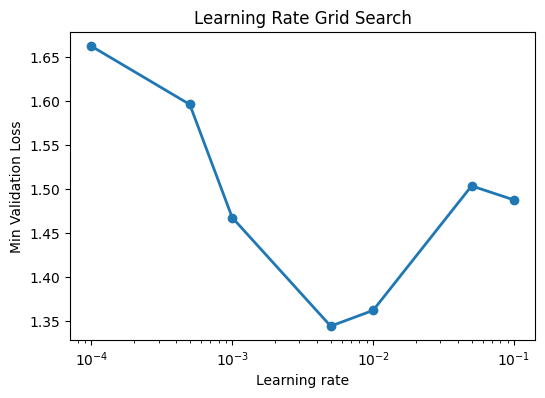

In [42]:
plt.figure(figsize=(6,4))
plt.xscale('log')   # good practice for learning rates
plt.xlabel("Learning rate")
plt.ylabel("Min Validation Loss")
print(result)
#plt.legend()
plt.title("Learning Rate Grid Search")
# print(result)
plt.plot(learning_rates, result, label="Grid Search(Validataion Loss)", linewidth=2, marker='o')

#**Clean Model**


In [45]:
min_index = result.index(min(result))
learning_rate = learning_rates[min_index]
print(f"Best learning rate: {learning_rate}, Min val loss: {result[min_index]}")

Best learning rate: 0.005, Min val loss: 1.3441717624664307


In [46]:
model = initialize_model(device)
losses,val_losses = train_with_mvr2_once(model,criterion,train_loader,val_loader,learning_rate,epochs)

[1] loss: 2.131 val_loss:4.4267578125 current_lr=0.004996
[2] loss: 1.679 val_loss:2.0331006050109863 current_lr=0.004982
[3] loss: 1.549 val_loss:1.7164182662963867 current_lr=0.004960
[4] loss: 1.464 val_loss:1.7641631364822388 current_lr=0.004929
[5] loss: 1.398 val_loss:1.689769983291626 current_lr=0.004890
[6] loss: 1.368 val_loss:1.5780044794082642 current_lr=0.004842
[7] loss: 1.293 val_loss:1.5704905986785889 current_lr=0.004786
[8] loss: 1.218 val_loss:1.5204949378967285 current_lr=0.004722
[9] loss: 1.133 val_loss:1.6201958656311035 current_lr=0.004650
[10] loss: 1.086 val_loss:1.6461386680603027 current_lr=0.004570
[11] loss: 1.010 val_loss:1.6585540771484375 current_lr=0.004484
[12] loss: 1.030 val_loss:1.59865140914917 current_lr=0.004390
[13] loss: 0.954 val_loss:1.631764531135559 current_lr=0.004290
[14] loss: 0.895 val_loss:1.5670397281646729 current_lr=0.004184
[15] loss: 0.832 val_loss:1.4882084131240845 current_lr=0.004073
[16] loss: 0.773 val_loss:1.422713041305542 

In [47]:
losses_mvr2 = losses

In [48]:

ResNet18 = initialize_model(device)

#**SGD Training Loop**

In [49]:
learning_rate = 0.1
optimizer = optim.SGD(ResNet18.parameters(), lr=learning_rate, weight_decay=0.01)

In [50]:

# Cosine annealing: lr → eta_min by the end
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,   # period (usually = total epochs)
    eta_min=0.1*learning_rate      # minimum LR (here 0.1× of 0.01)
)
losses = []
for epoch in range(epochs):
    ResNet18.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ResNet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
     # step the scheduler once per epoch
    scheduler.step()
    losses.append(running_loss/max(1, len(train_loader)))
    current_lr = scheduler.get_last_lr()[0]  # single param group
    print(f"[{epoch+1}] loss: {losses[-1]:.3f} lr={current_lr:.6f}")

print("Training finished!")

[1] loss: 3.068 lr=0.099911
[2] loss: 2.000 lr=0.099645
[3] loss: 1.707 lr=0.099203
[4] loss: 1.570 lr=0.098586
[5] loss: 1.530 lr=0.097798
[6] loss: 1.413 lr=0.096840
[7] loss: 1.339 lr=0.095717
[8] loss: 1.317 lr=0.094434
[9] loss: 1.199 lr=0.092995
[10] loss: 1.129 lr=0.091406
[11] loss: 1.100 lr=0.089673
[12] loss: 1.086 lr=0.087804
[13] loss: 0.920 lr=0.085805
[14] loss: 0.852 lr=0.083684
[15] loss: 0.915 lr=0.081450
[16] loss: 0.801 lr=0.079112
[17] loss: 0.769 lr=0.076679
[18] loss: 0.677 lr=0.074160
[19] loss: 0.708 lr=0.071566
[20] loss: 0.630 lr=0.068906
[21] loss: 0.522 lr=0.066191
[22] loss: 0.533 lr=0.063432
[23] loss: 0.416 lr=0.060640
[24] loss: 0.358 lr=0.057826
[25] loss: 0.409 lr=0.055000
[26] loss: 0.308 lr=0.052174
[27] loss: 0.277 lr=0.049360
[28] loss: 0.293 lr=0.046568
[29] loss: 0.290 lr=0.043809
[30] loss: 0.178 lr=0.041094
[31] loss: 0.105 lr=0.038434
[32] loss: 0.186 lr=0.035840
[33] loss: 0.172 lr=0.033321
[34] loss: 0.160 lr=0.030888
[35] loss: 0.115 lr=0.0

In [51]:
losses_sgd = [x for x in losses]

#**show losses for two optimizer**

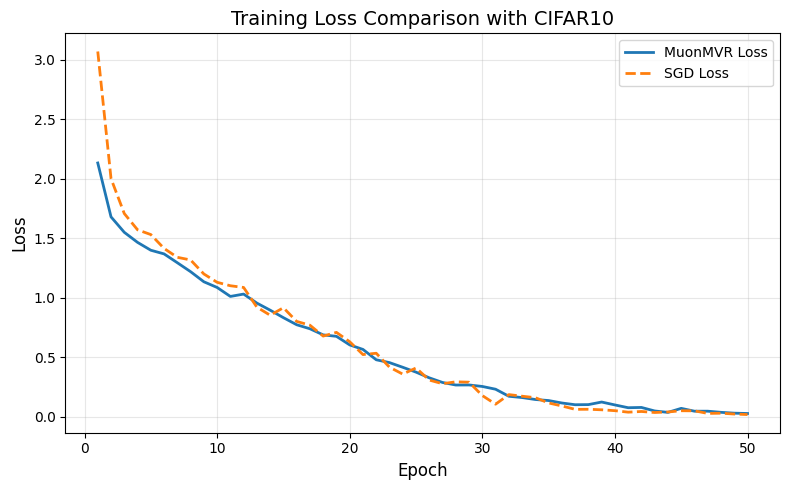

In [52]:
epochs_list = range(1,epochs+1)
plt.figure(figsize=(8, 5))  # larger, readable figure

# plot both losses
plt.plot(epochs_list, losses_mvr2, label="MuonMVR Loss", linewidth=2)
plt.plot(epochs_list, losses_sgd, label="SGD Loss", linewidth=2, linestyle="--")

# formatting
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Comparison with CIFAR10", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#**Testing Loop**
The real test of the model architecture how well does the model recognizes the image and what is the accuracy on the test data

In [ ]:
# ResNet18.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = ResNet18(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy: {100 * correct / total:.2f}%")